# 7. 🤖 Model Training and Evaluation



This notebook demonstrates how to train and evaluate machine learning models using the 3WToolkit. We will cover a complete workflow from data preparation to model assessment, including:

- Loading and preprocessing the 3W dataset
- Training MLP models with different configurations
- Evaluating model performance using various metrics
- Visualizing training history and results

## Learning Objectives

By the end of this notebook, you will be able to:
- Configure and train MLP models using the 3WToolkit
- Evaluate model performance using comprehensive metrics
- Visualize training progress and model predictions
- Understand the complete model training workflow


## Required Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from pathlib import Path

from ThreeWToolkit.preprocessing import Windowing
from ThreeWToolkit.core.base_preprocessing import WindowingConfig
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig
from ThreeWToolkit.core.base_assessment import ModelAssessmentConfig
from ThreeWToolkit.assessment.model_assess import ModelAssessment
from ThreeWToolkit.core.enums import TaskType


### 1. Load Dataset

Let's create a ParquetDataset that loads cleaned data with target classes 0, 1, and 2

In [2]:
# Define dataset path
dataset_path = Path("../../dataset")

# Create and load dataset with target classes 0, 1, and 2
ds_config = ParquetDatasetConfig(
    path=dataset_path, 
    clean_data=True, 
    target_class=[0, 1, 2]
)
ds = ParquetDataset(ds_config)

print("Dataset loaded successfully!")
print(f"Total events: {len(ds)}")


[ParquetDataset] Dataset found at ../../dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
Dataset loaded successfully!
Total events: 760


### 2. Load Model and Trainer Setup



**II. Instantiating configuration classes for the MLP model, Training parameters, and Evaluation parameters.**

With the ParquetDataset instance defined, we can set the parameters for the MLP model using the MLPConfig object. These parameters will be combined with the TrainerConfig and managed through the ModelTrainer, which encapsulates the training workflow.

The defined workflow controls most relevant parameters that will be used for training of a model. 

Finally, the ModelTrainer is instantiated with the training configuration, while the ModelAssessment object prepares the evaluation pipeline. The model architecture can be visualized by printing the `trainer.model`.


In [3]:
# Define window size for the model
window_size = 100

# Configure the MLP model
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(32, 16),
    output_size=3,  # 3 classes
    random_seed=11,
    activation_function="relu",
    regularization=None,
)

# Configure the trainer
trainer_config = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=False,
    shuffle_train=True,
)

# Configure model assessment
assessment_config = ModelAssessmentConfig(
    metrics=["balanced_accuracy", "precision", "recall", "f1"],
    task_type=TaskType.CLASSIFICATION,
    class_names=["Class_0", "Class_1", "Class_2"],
    export_results=True,
    generate_report=False,
)

# Initialize trainer and assessor
trainer = ModelTrainer(trainer_config)
assessor = ModelAssessment(assessment_config)

# Display the model architecture
print("Model Architecture:")
print(trainer.model)


Model Architecture:
MLP(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)


### 3. Data Preprocessing with Windowing

The next step is to iterate over a dataset of time series events, applying a windowing function to a selected signal column, in this case `T-TPT`.

All windowed segments from all events are then concatenated into a single DataFrame (dfs_final). This prepares the data for supervised training, where each row represents a windowed segment with its corresponding class label.


In [4]:
# Select target columns and prepare training data with windowing
selected_col = "T-TPT"
dfs = []

# Configure windowing
wind = Windowing(WindowingConfig(
    window="hann",
    window_size=window_size,
    overlap=0.5,
    pad_last_window=True
))

print("Processing events with windowing...")
for event in tqdm(ds):
    # Apply windowing to the selected column
    windowed_signal = wind(event["signal"][selected_col])
    # Remove the window column (not needed for training)
    windowed_signal.drop(columns=["win"], inplace=True)
    # Add the label for this event
    windowed_signal["label"] = np.unique(event["label"]["class"])[0]
    dfs.append(windowed_signal)
# Concatenate all windowed data
dfs_final = pd.concat(dfs, ignore_index=True, axis=0)


print("Preprocessing completed!")
print(f"Total windows: {len(dfs_final)}")
print(f"Window size: {window_size}")
print(f"Features per window: {dfs_final.shape[1] - 1}")  # -1 for label column
print("Label distribution:")
print(dfs_final["label"].value_counts().sort_index())


Processing events with windowing...


100%|██████████| 760/760 [00:25<00:00, 29.95it/s]


Preprocessing completed!
Total windows: 440356
Window size: 100
Features per window: 100
Label distribution:
label
0    243441
1    182146
2     14769
Name: count, dtype: int64


### 4. Model Training


Finally we can call the train function using the trainer object.


In [5]:
# Prepare training data
x_train = dfs_final.iloc[:, :-1]  # All columns except the last one (label)
y_train = dfs_final["label"].astype(int)  # Convert labels to integers

print("Starting model training...")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")

# Train the MLP model using the ModelTrainer interface
trainer.train(x_train=x_train, y_train=y_train)

print("Training completed!")


Starting model training...
Training data shape: (440356, 100)
Training labels shape: (440356,)


[Pipeline] Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training completed!


### 5. Model Evaluation and Assessment

The trainer class allows direct evaluation of the trained model using the `assess` method, which returns a dictionary containing performance metrics and evaluation parameters.


In [6]:
# Method 1: Direct assessment using trainer
print("=== Method 1: Direct Assessment using Trainer ===")
trainer_results = trainer.assess(x_train, y_train, assessment_config)


=== Method 1: Direct Assessment using Trainer ===
Results exported to /home/rafael/pos-doc/repos/3W/toolkit/output
Model Assessment Summary
Model: MLP
Task Type: TaskType.CLASSIFICATION
Timestamp: 2025-10-15T19:40:01.565880

Metrics:
  balanced_accuracy: 0.9453
  precision: 0.9631
  recall: 0.9615
  f1: 0.9613


**Another option, and the most recommended one, is to use the `ModelAssessment` class to perform the evaluation of the results.**


In [7]:
# Method 2: Using ModelAssessment class (recommended)
print("\n=== Method 2: Using ModelAssessment Class (Recommended) ===")
results = assessor.evaluate(trainer.model, x_train, y_train)
print("\nDetailed Results:")
print(results)



=== Method 2: Using ModelAssessment Class (Recommended) ===
Results exported to /home/rafael/pos-doc/repos/3W/toolkit/output
Model Assessment Summary
Model: MLP
Task Type: TaskType.CLASSIFICATION
Timestamp: 2025-10-15T19:40:05.856414

Metrics:
  balanced_accuracy: 0.9453
  precision: 0.9631
  recall: 0.9615
  f1: 0.9613

Detailed Results:
{'model_name': 'MLP', 'task_type': <TaskType.CLASSIFICATION: 'classification'>, 'predictions': array([2, 2, 2, ..., 0, 0, 0], shape=(440356,)), 'true_values': array([2, 2, 2, ..., 0, 0, 0], shape=(440356,)), 'X_test': array([[0.        , 0.00051192, 0.00204574, ..., 0.00459149, 0.00204418,
        0.00051159],
       [0.        , 0.00051175, 0.0020449 , ..., 0.00458746, 0.00204227,
        0.00051108],
       [0.        , 0.00051167, 0.00204482, ..., 0.00459149, 0.00204405,
        0.00051153],
       ...,
       [0.        , 0.000307  , 0.00122664, ..., 0.00274646, 0.00122265,
        0.00030596],
       [0.        , 0.00030587, 0.00122227, ..., 0. 

In [8]:
# Display summary metrics
print("=== Model Performance Summary ===")
print(assessor.summary())


=== Model Performance Summary ===
Model Assessment Summary
Model: MLP
Task Type: TaskType.CLASSIFICATION
Timestamp: 2025-10-15T19:40:05.856414

Metrics:
  balanced_accuracy: 0.9453
  precision: 0.9631
  recall: 0.9615
  f1: 0.9613



The trainer object also collects a history of validation and training loss that can be visualized after the training is completed.


### 6. Training History Visualization

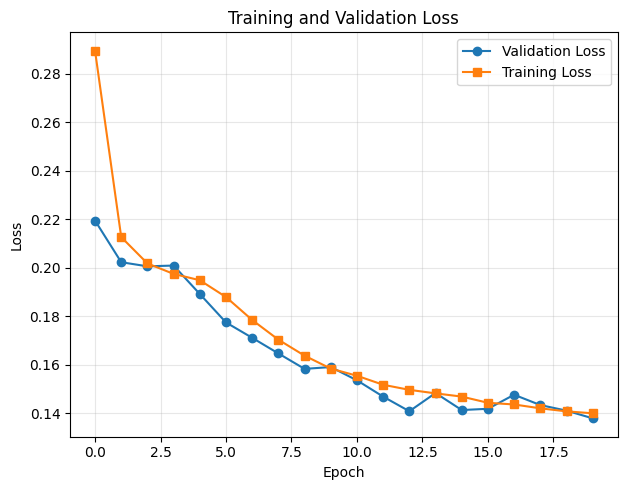

=== Final Training Statistics ===
Final Training Loss: 0.1401
Final Validation Loss: 0.1380


In [9]:
# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(trainer.history[0]["val_loss"], label="Validation Loss", marker='o')
plt.plot(trainer.history[0]["train_loss"], label="Training Loss", marker='s')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final training statistics
print("=== Final Training Statistics ===")
print(f"Final Training Loss: {trainer.history[0]['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {trainer.history[0]['val_loss'][-1]:.4f}")
